In [240]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
np.random.seed(42)# Set random seed to get the same result every time

In [241]:
# Define cities data manually
cities_data = {
    'City': [
        'Ankara', 'Istanbul', 'Izmir', 'Antalya', 'Bursa',
        'Adana', 'Konya', 'Trabzon', 'Gaziantep', 'Kayseri',
        'Samsun', 'Eskişehir', 'Mersin', 'Edirne', 'Erzurum',
        'Erzincan', 'Niğde', 'Batman', 'Balıkesir', 'Aydın'
    ],
    'X': [
        39.9334, 41.0082, 38.4192, 36.8969, 40.1828,
        37.0000, 37.8746, 41.0015, 37.0662, 38.7312,
        41.2867, 39.7767, 36.8121, 38.3552, 39.9043,
        38.4942, 37.7765, 38.6191, 39.6484, 37.8481
    ],
    'Y': [
        32.8597, 28.9784, 27.1287, 30.7133, 29.0665,
        35.3213, 32.4918, 39.7178, 37.3833, 35.4787,
        36.3308, 30.5206, 34.6415, 38.3095, 41.2679,
        43.3832, 29.0864, 27.4289, 27.8826, 27.8456
    ]
}

In [242]:
# Create DataFrame
df = pd.DataFrame(cities_data)

In [243]:
# Save the city data as a CSV file
df.to_csv('cities.csv', index=False)

In [244]:
# Reading the csv file with pandas
df=pd.read_csv('cities.csv')

In [245]:
# Get city names and coordinates from the dataframe
city_names = df['City'].tolist()
city_coords = df[['X', 'Y']].values

In [246]:
# Abstract Individual Class (for genetic algorithm)
class Individual(ABC):
    @abstractmethod
    def pair(self, other, pair_params):
        pass

    @abstractmethod
    def mutate(self, mutate_params):
        pass

    @abstractmethod
    def fitness(self):
        pass

In [247]:
# TSP Individual Class
class TSP(Individual):
    def __init__(self, route=None, city_coords=None):
        self.city_coords = city_coords
        if route is not None:
            self.route = route
        else:
            # Create random city order
            self.route = np.random.permutation(len(city_coords))
        self._fitness = self.fitness()

    def total_distance(self):
        distance = 0
        for i in range(len(self.route)):
            from_city = self.city_coords[self.route[i]]
            to_city = self.city_coords[self.route[(i + 1) % len(self.route)]]
            distance += np.linalg.norm(from_city - to_city)
        return distance

    def fitness(self):
        # We want small distance, so we return negative value
        return -self.total_distance()

    def pair(self, other, pair_params):
        # Crossover: take part from this and part from other
        cut = np.random.randint(1, len(self.route) - 1)
        child_route = list(self.route[:cut])
        for city in other.route:
            if city not in child_route:
                child_route.append(city)
        return TSP(route=np.array(child_route), city_coords=self.city_coords)

    def mutate(self, mutate_params):
        # Swap two cities in the route
        for _ in range(mutate_params.get('num_swaps', 1)):
            i, j = np.random.randint(0, len(self.route), size=2)
            self.route[i], self.route[j] = self.route[j], self.route[i]
        self._fitness = self.fitness()


In [248]:
# Population Class
class Population:
    def __init__(self, size, individual_class, city_coords):
        # Create many individuals (routes)
        self.individuals = [individual_class(city_coords=city_coords) for _ in range(size)]
        self.individuals.sort(key=lambda x: x.fitness())

    def replace(self, new_individuals):
        size = len(self.individuals)
        self.individuals.extend(new_individuals)
        self.individuals.sort(key=lambda x: x.fitness())
        self.individuals = self.individuals[-size:]

    def get_parents(self, n_offsprings):
        # Select parents from the best individuals
        mothers = self.individuals[-2 * n_offsprings::2]
        fathers = self.individuals[-2 * n_offsprings + 1::2]
        return mothers, fathers

In [249]:

# Evolution Class (for running the algorithm)
class Evolution:
    def __init__(self, pool_size, individual_class, n_offsprings, pair_params, mutate_params, city_coords):
        self.pair_params = pair_params
        self.mutate_params = mutate_params
        self.pool = Population(pool_size, individual_class, city_coords)
        self.n_offsprings = n_offsprings

    def step(self):
        # Create new generation
        mothers, fathers = self.pool.get_parents(self.n_offsprings)
        offsprings = []

        for mother, father in zip(mothers, fathers):
            offspring = mother.pair(father, self.pair_params)
            offspring.mutate(self.mutate_params)
            offsprings.append(offspring)

        self.pool.replace(offsprings)

In [250]:
# Parameters
pair_params = {}
mutate_params = {'num_swaps': 2}

# Create and run the evolution
evo = Evolution(
    pool_size=100,
    individual_class=TSP,
    n_offsprings=50,
    pair_params=pair_params,
    mutate_params=mutate_params,
    city_coords=city_coords
)

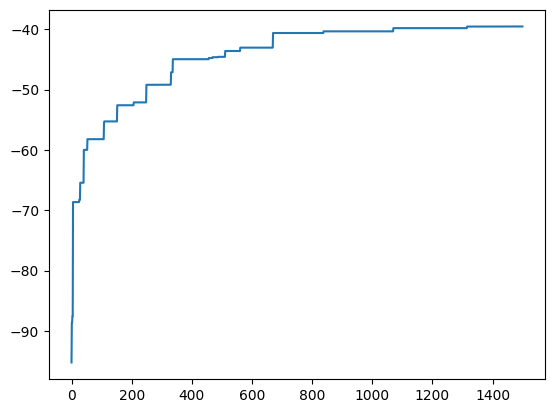

In [251]:
# Run for 100 generations
fitness_list = []
for generation in range(1500):
    fitness_list.append(evo.pool.individuals[-1].fitness())
    evo.step()  
plt.plot(fitness_list)
plt.show()    
   

In [252]:
# Get the best route
best = evo.pool.individuals[-1]
best_route_indices = best.route
best_route_names = [city_names[i] for i in best_route_indices]
total_distance = -best.fitness()

In [253]:
print(best_route_indices)

[15 13  8  9  5 12  6  3 16 19  2 17 18  1  4 11  0 10  7 14]


In [254]:

# Beautified output
print("BEST ROUTE FOUND BY GENETIC ALGORITHM")

for i, city in enumerate(best_route_names):
    print(f"{i+1:2d}. {city}")

# Return to the starting point
print(f"{len(best_route_names)+1:2d}. {best_route_names[0]} (Return to Start)")

print(f"Total Distance of the Route: {total_distance:.2f} units")

BEST ROUTE FOUND BY GENETIC ALGORITHM
 1. Erzincan
 2. Edirne
 3. Gaziantep
 4. Kayseri
 5. Adana
 6. Mersin
 7. Konya
 8. Antalya
 9. Niğde
10. Aydın
11. Izmir
12. Batman
13. Balıkesir
14. Istanbul
15. Bursa
16. Eskişehir
17. Ankara
18. Samsun
19. Trabzon
20. Erzurum
21. Erzincan (Return to Start)
Total Distance of the Route: 39.55 units


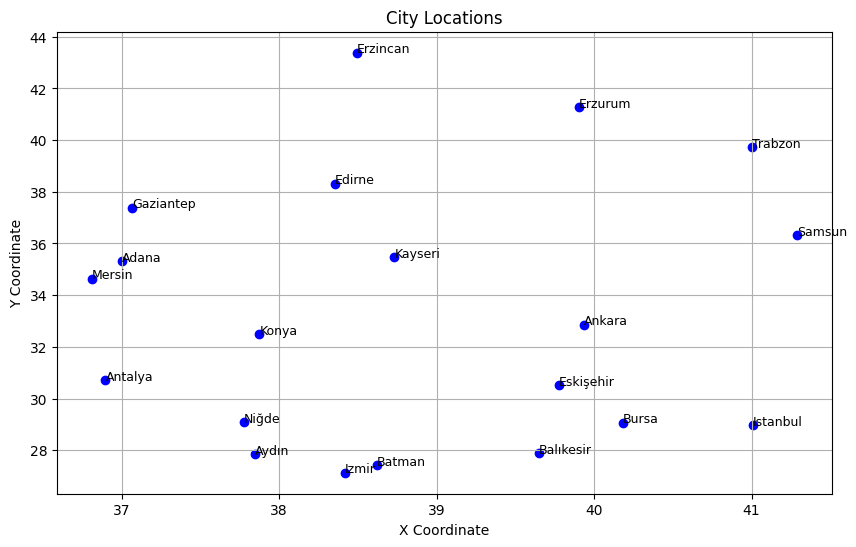

In [255]:
# Show cities only (no lines)
plt.figure(figsize=(10, 6))
plt.scatter(city_coords[:, 0], city_coords[:, 1], color='blue')
for i, name in enumerate(city_names):
    plt.text(city_coords[i, 0], city_coords[i, 1], name, fontsize=9)
plt.title('City Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

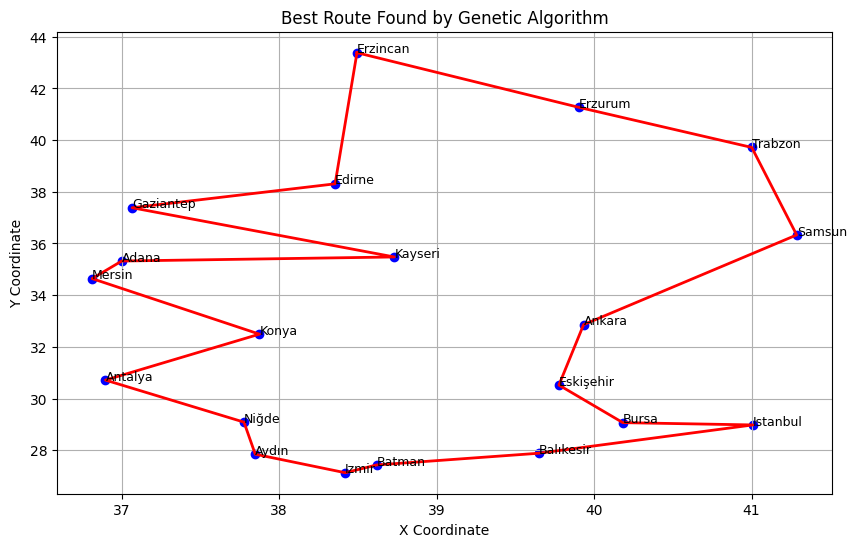

In [256]:
# Show the best route (with lines)
route_coords = city_coords[best.route]
route_coords = np.vstack([route_coords, route_coords[0]])  # Return to start

plt.figure(figsize=(10, 6))
plt.scatter(city_coords[:, 0], city_coords[:, 1], color='blue')
for i, name in enumerate(city_names):
    plt.text(city_coords[i, 0], city_coords[i, 1], name, fontsize=9)

plt.plot(route_coords[:, 0], route_coords[:, 1], color='red', linewidth=2)
plt.title('Best Route Found by Genetic Algorithm')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()